
WorkFlow progress
Obiettivo è quello di riuscire a costruire un modello CNN in grado di prevedere accuratamente la classe di rifiuti di un immagine data in input, ricercando tra vari kaggle su lavori simili ho notato che l utilizzo della Resnet sembra essere uno di quello di quelli piu utilizzati. Sviluppero quindi un modello ResNet che riesca accuratamente e prevedere. Perche di alcune scelte:
immagini di dimensioni 224x224, le immagini del dataset sono tutte di dimensioni 524 x 524, il che potrebbe essere pesante per un modello Custom da trainare, inoltre vorrei poter confrontare il nostro modello con un modello pre trainato come il modello resnet18 gia pretrainato e funzionate, il quale è stato trainato su immagini da 224x224.  (devo implementarlo)
Spiegazione delle Architetture Implementate
aggiunta di dropout ecc
Questo dimostra ai professori che hai preso un'architettura standard (ResNet) e l'hai adattata al tuo problema specifico (dataset più piccolo -> necessità di regolarizzazione). È una mossa molto intelligente.


# Config of Hyperparameters


Cambiare i parametri sotto per poter cambiare epoche learning rate o il tipo da modello da trainare. Assicuratevi di stare nella directoy giusta e di scaricare il dataset nella stessa directory dove tenete il notebook. Cambiate i valori che vi servono poi semplicemente runnate tutto per far partire il training. per il fare l evaluation sul dataset che creerete guardate l ultima cella. guardare la cartella che verra creata con  "outputs" per i risultati. Assicuratevi di mettere il path del vostro dataset. Se vi mancano degli import prendete il file requirements scaricatelo, mettetevi nella cartella del file e scrivete nel terminale o di vscode o cmd  pip install -r requirements.txt

In [ ]:
import os
import torch
import  matplotlib.pyplot as plt
import time
import copy
from tqdm.notebook import tqdm
import cv2
from collections import Counter
import shutil
import glob
from sklearn.model_selection import train_test_split
from src import config 
import pickle
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- PERCORSI ---
# Se siamo su Kaggle o in Locale
if os.path.exists('/kaggle/input'):
    DATA_ROOT = '/kaggle/input/waste-classification'
    OUTPUT_DIR = '/kaggle/working/output'

    
else:
    DATA_ROOT = './data/raw' # Metti qui il tuo dataset locale
    if not os.path.exists('./outputs'):
        os.makedirs('./outputs')
    else:    
        OUTPUT_DIR = './outputs'  #

PROCESSED_DATA_DIR = os.path.join(OUTPUT_DIR, 'processed_data')


# --- CONFIGURAZIONE ESPERIMENTO ---
# Scegli qui quale modello allenare!
# Opzioni disponibili (basate sul tuo codice):
# 1. 'custom_resnet'     -> La tua ResNet fatta a mano (From Scratch)
# 2. 'pretrained_resnet' -> La ResNet18 di ImageNet (Transfer Learning)
# 3. 'custom_vgg'        -> La tua VGG fatta a mano (From Scratch)
 
# <--- CAMBIA QUESTO PER TESTARE DIVERSI MODELLI --->
# MODEL_NAME = 'custom_resnet' # DECOMENTA QUI PER TESTARE IL MODELLO RESNET CUSTOM PERSONALIZZATO E COMMENTA GLI ALTRI
MODEL_NAME = 'custom_vgg' # DECOMENTA QUI PER TESTARE IL MODELLO VGG PERSONALIZZATO E COMMENTA GLI ALTRI
# MODEL_NAME = 'pretrained_resnet' # DECOMENTA QUI PER TESTARE IL MODELLO RESNET PRETRAINATO O E COMMENTA GLI ALTRI

#model version = da ggiungere per nuove versioni del modello

# --- IPERPARAMETRI (STATISTICI, TOCCATE QUI!) ---
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# on colab use2 or 4 workers depending on the instance
NUM_WORKERS = 0 # Numero di workers per il DataLoader (0 = main thread) 
NUM_CLASSES = 9 # Numero di classi nel dataset
CRITERION = nn.CrossEntropyLoss() # Funzione di perdita 


# --- PARAMETRI DATASET ---
IMG_SIZE = 224
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
SEED = 42 

Seeing the dataset

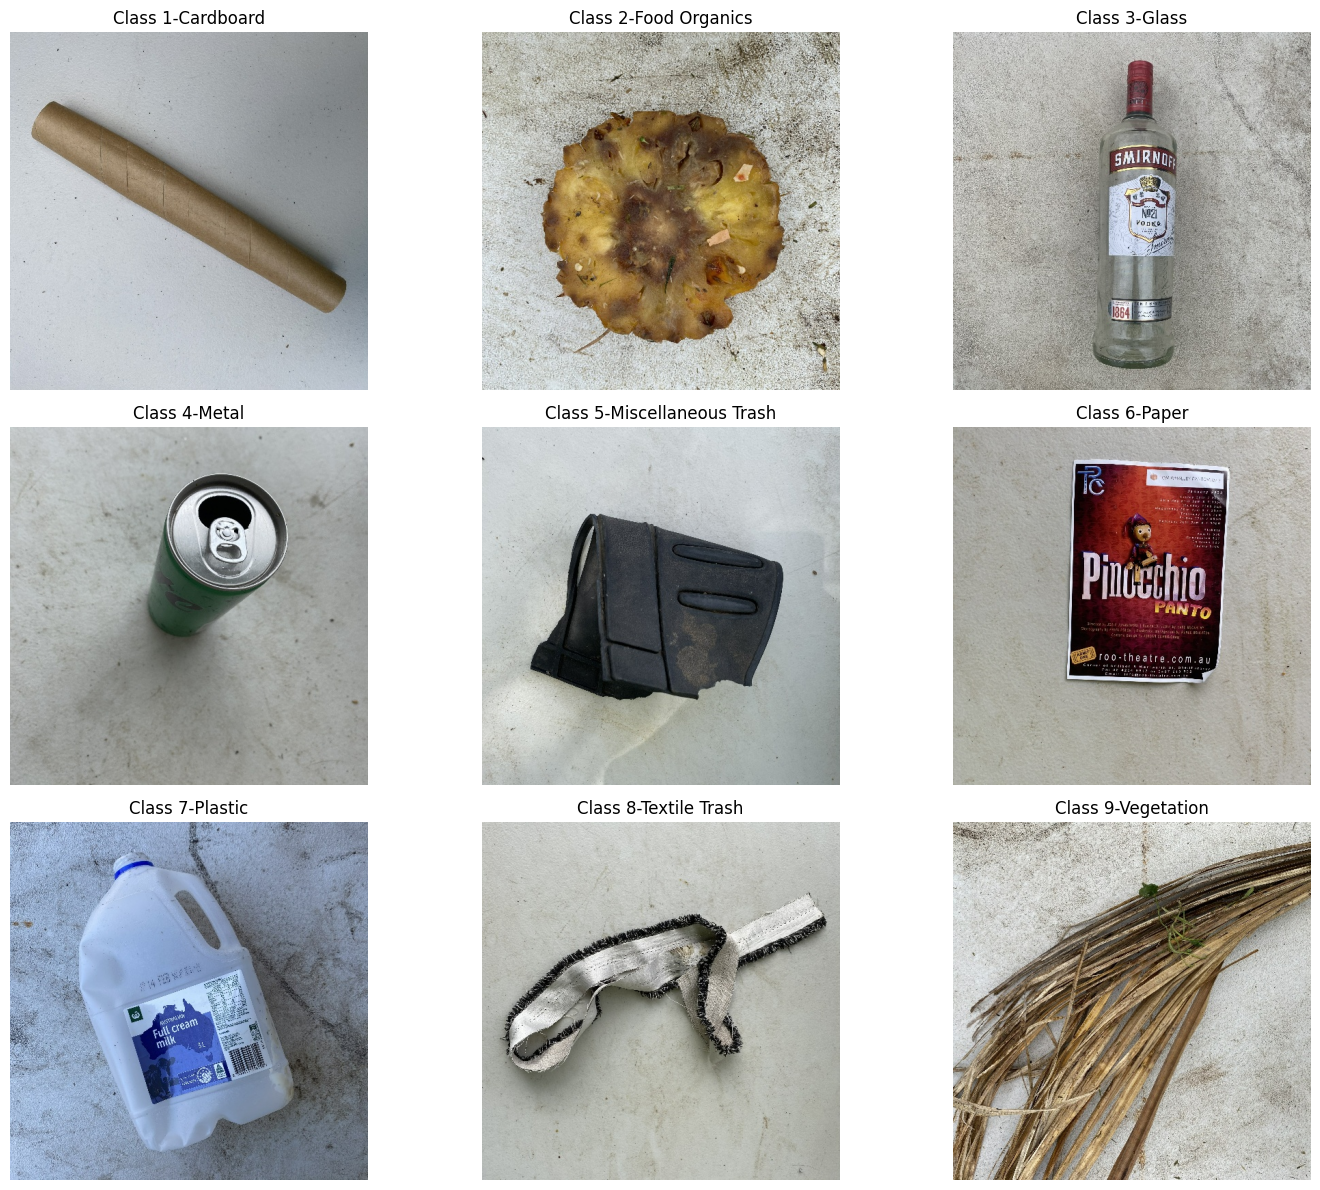

In [ ]:
#Vidualize some samples from the dataset
classes = os.listdir(DATA_ROOT)
n = len(classes)
cols = 3
rows = (n + cols - 1) // cols
plt.figure(figsize=(cols*5, rows*4))
for i,c in enumerate(classes,1):
    ax = plt.subplot(rows, cols, i)
    ax.set_title(f"Class {c}")
    img_path = os.path.join(DATA_ROOT, c, os.listdir(os.path.join(DATA_ROOT, c))[0])
    ax.imshow(plt.imread(img_path))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# # Piccolo codice per analizzare le dimensioni delle immagini nel dataset, commentato perché non più necessario


# classes = sorted(os.listdir(DATA_ROOT))
# for c in classes:
#     class_path = os.path.join(DATA_ROOT, c)
#     imgs = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
#     n_images = len(imgs)
#     sizes = []
#     for img in imgs:
#         p = os.path.join(class_path, img)
#         im = cv2.imread(p)
#         if im is None:
#             print(f"  Warning: can't read {p}")
#             continue
#         h, w = im.shape[:2]
#         sizes.append((w, h))  # (width, height)

#     if sizes:
#         most_common, cnt = Counter(sizes).most_common(1)[0]
#         unique = len(set(sizes))
#         print(f"Class '{c}': {n_images} images — most common size: {most_common} ({cnt}), unique sizes: {unique}")
#     else:
#         print(f"Class '{c}': {n_images} images — no readable images")


Creating the dataloader and training validation test split


In [ ]:

def create_dataset_structure():
    """
    Reads raw data and creates Train/Val/Test structure
    """
    # 1. Check if dataset already exists and is not empty
    if os.path.exists(config.PROCESSED_DATA_DIR):
        if len(os.listdir(config.PROCESSED_DATA_DIR)) > 0:
            print(f"Dataset already in {config.PROCESSED_DATA_DIR}, skipping the split.")
            return
        else:
            print("Output folder exists but is empty. Proceeding...")

    print(f"Starting dataset split from: {config.DATA_ROOT}...")
    
    # 2. Detect classes automatically
    found_classes = set()
    for path, dirs, files in os.walk(config.DATA_ROOT):
        # Check for images (case insensitive)
        if any(f.lower().endswith(('.jpg', '.png', '.jpeg')) for f in files):
            parent = os.path.basename(path)
            
            # Handle numeric prefixes (e.g., "1-Plastic" -> "Plastic")
            if len(parent) > 2 and parent[1] == '-' and parent[0].isdigit():
                parent = parent[2:] 
            
            # Filter out system folders
            if parent not in ['TRAIN', 'TEST', 'DATASET', 'images', 'raw', 'data']:
                found_classes.add(parent)
    
    classes = sorted(list(found_classes))
    print(f"Classes Found: {classes}")

    if not classes:
        print("ERROR: No classes found! Check config.DATA_ROOT path.")
        return

    # 3. Perform the split
    total_images_count = 0
    
    for cls in classes:
        print(f"Processing class: '{cls}'...")
        
        # Robust search strategy: check exact name AND original folder names
        # We search recursively for files ending in common extensions (Case Insensitive logic)
        search_patterns = [
            f"{config.DATA_ROOT}/**/{cls}/*.jpg",
            f"{config.DATA_ROOT}/**/{cls}/*.JPG",
            f"{config.DATA_ROOT}/**/{cls}/*.png",
            f"{config.DATA_ROOT}/**/{cls}/*.PNG",
            f"{config.DATA_ROOT}/**/{cls}/*.jpeg"
        ]
        
        # Also search for folders with prefixes (e.g. searching for Plastic inside 1-Plastic)
        # This covers the case where we stripped the prefix in detection but need it for file path
        search_patterns.append(f"{config.DATA_ROOT}/**/?-{cls}/*.jpg") 
        
        files = []
        for pattern in search_patterns:
            found = glob.glob(pattern, recursive=True)
            files.extend(found)
        
        # Remove duplicates
        files = list(set(files))

        if not files:
            print(f"  WARNING: 0 files found for '{cls}'. Skipping...")
            continue

        total_images_count += len(files)

        # Split 70% Train - 15% Val - 15% Test
        train_files, temp = train_test_split(files, test_size=0.3, random_state=config.SEED)
        val_files, test_files = train_test_split(temp, test_size=0.5, random_state=config.SEED)

        # Physical copy
        splits = {'train': train_files, 'val': val_files, 'test': test_files}
        
        for split_name, split_files in splits.items():
            dest_dir = os.path.join(config.PROCESSED_DATA_DIR, split_name, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for f in split_files:
                try:
                    shutil.copy(f, dest_dir)
                except Exception as e:
                    print(f"Error copying {f}: {e}")
    
    if total_images_count == 0:
        print("ERROR: No images were copied. Please check your data structure.")
    else:
        print(f"Split completed! Total images processed: {total_images_count}")

def plot_results(history):
    """
    Generates and saves Loss and Accuracy plots
    """
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Ensure output directory exists
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    save_path = os.path.join(config.OUTPUT_DIR, 'training_plot.png')
    plt.savefig(save_path)
    print(f"Plots saved in: {save_path}")


def save_history(history, filename):
    """
    Save the training history to a file using pickle
    """
    # Ensure the output directory exists
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    
    filepath = os.path.join(config.OUTPUT_DIR, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(history, f)
    print(f"History salvata in: {filepath}")

In [ ]:
def get_dataloaders():
    """
    Returns DataLoaders for Train, Val, and Test
    """
    # Trasformations (Data Augmentation  only on Train)
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      #this number are from imagenet for resnet. we need to adjust the colors to resnet
        ]),
        'val': transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Dataset creation
    image_datasets = {x: datasets.ImageFolder(os.path.join(PROCESSED_DATA_DIR, x), 
                                              data_transforms[x])
                      for x in ['train', 'val', 'test']}

    # DataLoader creation
    dataloaders = {x: DataLoader(image_datasets[x], 
                                 batch_size=BATCH_SIZE, 
                                 shuffle=(x=='train'), # Shuffle only the train
                                 num_workers=NUM_WORKERS)
                   for x in ['train', 'val', 'test']}
    
    class_names = image_datasets['train'].classes
    
    return dataloaders, class_names

Model

In [ ]:


class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Assuming input images are 224x224
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:

# (Residual Block)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut
        # If we change dimensions (stride=2) or channels, we need to adapt the original x as well
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add the original input (shortcut) to the processed output
        out += self.shortcut(x) 
        out = F.relu(out)
        return out

# Convolutional Block for VGG-like architecture    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool_size=2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=2)

    def forward(self, x):
        return self.pool(self.relu(self.conv(x)))

#  THE COMPLETE ARCHITECTURE (ResNet18) 
class CustomResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        # Initial part (Stem)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The 4 stages of ResNet (each has multiple blocks)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # Dropout before the final layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Create a sequence of residual blocks
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        # Layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Head
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)                 #dropout before the final layer
        out = self.fc(out)
        return out

class Custom_VGG(nn.Module):
    def __init__(self, num_classes):
        super(Custom_VGG, self).__init__()
        
        # Feature Extractor: 4 blocchi che raddoppiano i canali
        self.features = nn.Sequential(
            ConvBlock(3, 32),   # Output: 112x112
            ConvBlock(32, 64),  # Output: 56x56
            ConvBlock(64, 128), # Output: 28x28
            ConvBlock(128, 256) # Output: 14x14
        )
        
        # Flatten size calcolato: 256 canali * 14 * 14 pixel = 50176
        self.flatten_dim = 256 * 14 * 14
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 512), 
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def initialize_model(num_classes, model_name='pretrained_resnet'):
    
    if model_name == 'pretrained_resnet':
        # pretrained model (Pre-trained)
        print("Initializing ResNet18 (Transfer Learning Pretrained - ImageNet)...")
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'custom_resnet':
        # Custom resnet model (From Scratch)
        print("Initializing Custom ResNet18 (Manual Structure)...")
        # The configuration [2, 2, 2, 2] creates a ResNet18
        model = CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    elif model_name == 'custom_vgg':
        #  Model Vgg-like del 
        print("Initializing Custom VGG-like model...")
        model = Custom_VGG(num_classes)    
    else:
        raise ValueError(f"Model {model_name} not recognized.")
        
    return model

In [ ]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    Main training function.
    """
    since = time.time()

    # Save history for final plots
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a Training and a Validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Enable dropout and batchnorm
            else:
                model.eval()   # Disable dropout (evaluation mode)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data (use tqdm for progress bar)
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase}", leave=False):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Zero the gradients
                optimizer.zero_grad()

                # --- FORWARD ---
                # Calculate gradients only if in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # --- BACKWARD + OPTIMIZE (Only in train) ---
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch metrics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Save in history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy of the model if it's the best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # print("  New record! Model saved.")

        print()

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

Avvio setup per: custom_vgg
Initializing Custom VGG-like model...
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Starting training for 20 epochs...
Epoch 1/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 2.1581 Acc: 0.1839


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 2.1319 Acc: 0.1938

Epoch 2/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 2.1090 Acc: 0.2149


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 2.0566 Acc: 0.2107

Epoch 3/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 2.0133 Acc: 0.2534


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.9424 Acc: 0.2992

Epoch 4/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.8981 Acc: 0.3142


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.7724 Acc: 0.3652

Epoch 5/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.7501 Acc: 0.3765


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.6675 Acc: 0.4031

Epoch 6/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.6400 Acc: 0.4036


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.5306 Acc: 0.4466

Epoch 7/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.5436 Acc: 0.4327


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.5216 Acc: 0.4466

Epoch 8/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.4837 Acc: 0.4529


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.4382 Acc: 0.4775

Epoch 9/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.4407 Acc: 0.4794


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3941 Acc: 0.5070

Epoch 10/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.4045 Acc: 0.4827


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3700 Acc: 0.5211

Epoch 11/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.3578 Acc: 0.5029


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3584 Acc: 0.5197

Epoch 12/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.3417 Acc: 0.5041


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3232 Acc: 0.5084

Epoch 13/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.3103 Acc: 0.5215


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3579 Acc: 0.5253

Epoch 14/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.2599 Acc: 0.5396


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2869 Acc: 0.5492

Epoch 15/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.2552 Acc: 0.5447


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2453 Acc: 0.5337

Epoch 16/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.2118 Acc: 0.5624


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.1577 Acc: 0.5815

Epoch 17/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.2198 Acc: 0.5570


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.1676 Acc: 0.5843

Epoch 18/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.1772 Acc: 0.5612


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.1432 Acc: 0.6067

Epoch 19/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.1473 Acc: 0.5751


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.0951 Acc: 0.6011

Epoch 20/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]

Train Loss: 1.1451 Acc: 0.5781


val:   0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.1493 Acc: 0.5913

Training completed in 43m 14s
Best val Acc: 0.606742
 Model saved at: ./outputs\custom_vgg_outputs\custom_vgg_best.pth
 History saved at: ./outputs\custom_vgg_outputs\custom_vgg_history.pkl


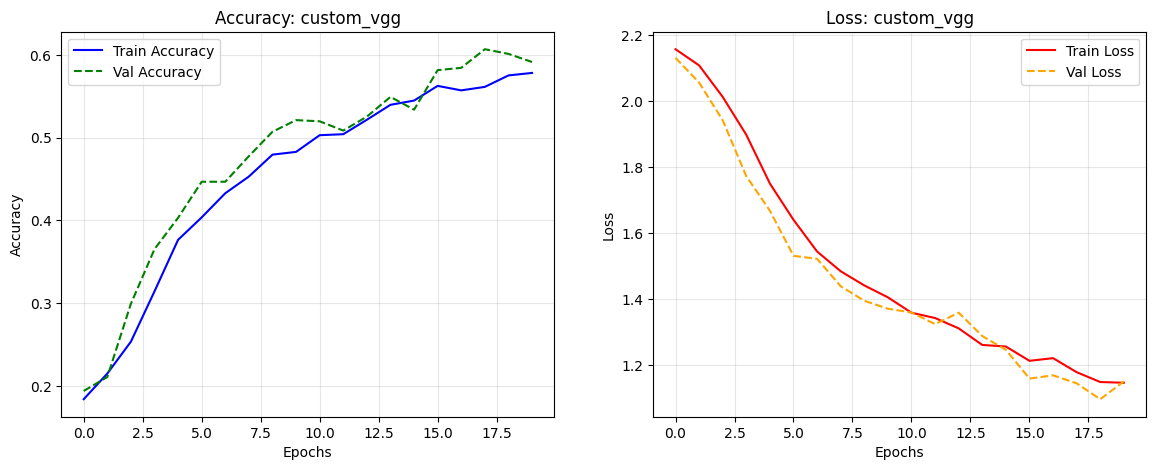

In [ ]:

print(f"Avvio setup per: {MODEL_NAME}")

# 1. Inizializza il modello
# Nota: len(class_names) viene dalla Cella 2 (che deve essere stata eseguita)
model = initialize_model(NUM_CLASSES, model_name=MODEL_NAME)
model = model.to(DEVICE)

# 2. Definisci Loss e Optimizer
# CrossEntropy è standard per classificazione multiclasse
criterion = CRITERION
dataloaders, class_names = get_dataloaders()
print(f"Classes: {class_names}")

# SGD con Momentum è ottimo per le ResNet
# Se usi 'custom_resnet', potresti provare anche lr=0.01 o lr=0.001
optimizer = optim.SGD(model.parameters(), LEARNING_RATE, momentum=0.9)

# 3. AVVIO TRAINING
try:
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    model_trained, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)
    
    # 4. SAVING
    #crea una directory per il modello se non esiste
    model_dir = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_outputs')
    os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
    save_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
    torch.save(model_trained.state_dict(), save_path)
    print(f" Model saved at: {save_path}")

    # Save training history
    history_path = os.path.join(model_dir, f"{MODEL_NAME}_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f" History saved at: {history_path}")

    #saving the csv file for excel
    csv_path = os.path.join(model_dir, f"{MODEL_NAME}_history.csv")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
            df = pd.DataFrame(history)
            df['epoch'] = range(1, len(df) + 1)
            df.to_csv(csv_path, index=False)
            print(f"CSV saved here: {csv_path}")  
            # Mostra le prime righe
            print(df.head())
    else:
        print("Errore: Non trovo il file .pkl. Controlla il percorso.")
    # 5. RESULTS PLOTS
    plt.figure(figsize=(14, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['val_acc'], label='Val Accuracy', color='green', linestyle='--')
    plt.title(f'Accuracy: {MODEL_NAME}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Grafico Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='red')
    plt.plot(history['val_loss'], label='Val Loss', color='orange', linestyle='--')
    plt.title(f'Loss: {MODEL_NAME}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plot_path = os.path.join(model_dir, f"{MODEL_NAME}_plot.png")
    plt.savefig(plot_path, dpi=300) # dpi=300 serve per alta risoluzione (stampa)
    print(f"Png of plot saved in  {plot_path}")
    plt.show()

except KeyboardInterrupt:
    print("\n Training manually interrupted by the user.")

Evaluation on TEST SET

Initializing Custom VGG-like model...
⚖️ Caricamento pesi da: ./outputs\custom_vgg_outputs\custom_vgg_best.pth
Avvio valutazione sul Test Set (717 immagini)...


Testing:   0%|          | 0/23 [00:00<?, ?it/s]

Risultati dettagliati salvati in CSV: ./outputs\custom_vgg_outputs\custom_vgg_test_results.csv

📝 CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard       0.60      0.53      0.56        70
      Food Organics       0.80      0.66      0.73        62
              Glass       0.93      0.65      0.77        63
              Metal       0.54      0.63      0.58       119
Miscellaneous Trash       0.38      0.47      0.42        75
              Paper       0.71      0.69      0.70        75
            Plastic       0.61      0.63      0.62       139
      Textile Trash       0.59      0.35      0.44        48
         Vegetation       0.72      0.92      0.81        66

           accuracy                           0.62       717
          macro avg       0.65      0.62      0.63       717
       weighted avg       0.64      0.62      0.62       717

Matrice salvata in: ./outputs\custom_vgg_outputs\custom_vgg_confusion_matrix.png


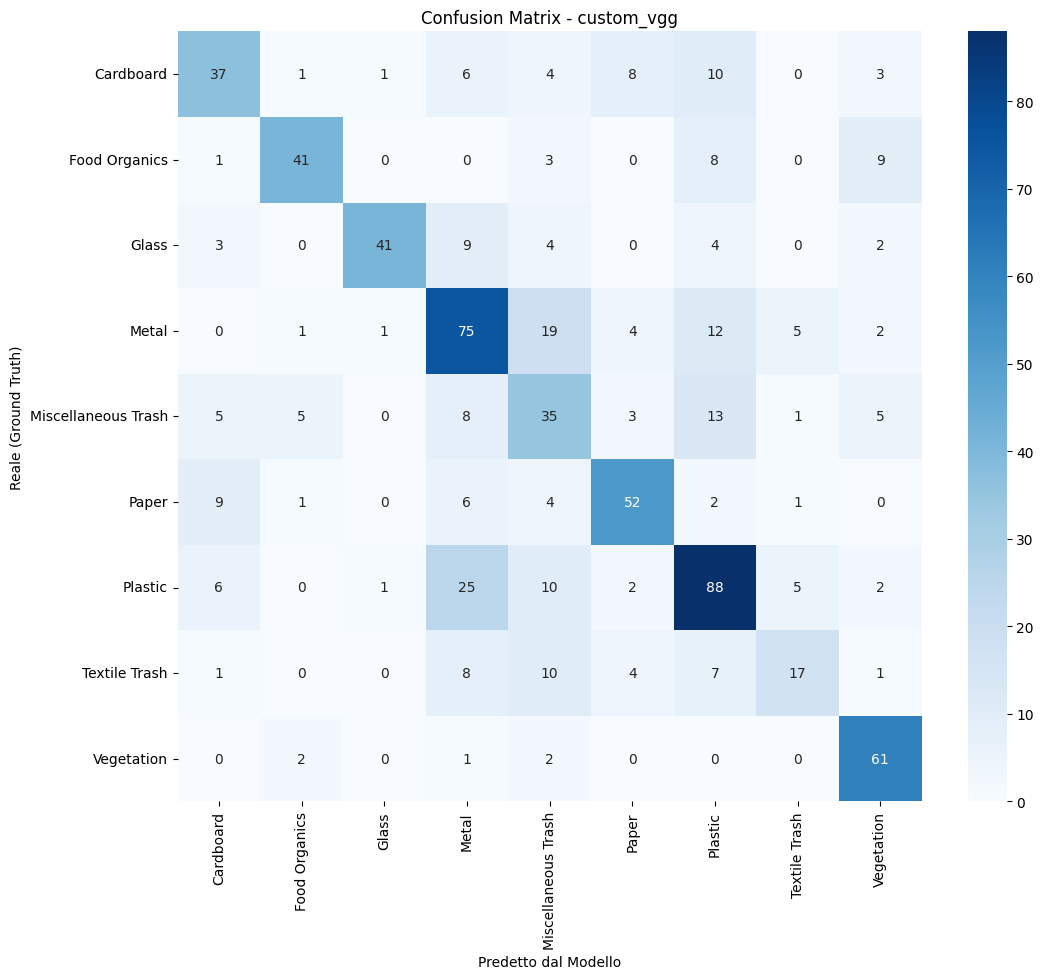

In [ ]:
import torch
import numpy as np

from tqdm.notebook import tqdm

# --- 1. PREPARAZIONE MODELLO ---
# Ricrea l'architettura pulita
model = initialize_model(len(class_names), model_name=MODEL_NAME)
model = model.to(DEVICE)

# Costruisci il percorso dei pesi migliori
model_dir = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_outputs')
weights_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")

# Carica i pesi
if os.path.exists(weights_path):
    print(f"⚖️ Caricamento pesi da: {weights_path}")
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
else:
    print(f"⚠️ ATTENZIONE: File pesi non trovato! I risultati saranno casuali.")

# Metti in modalità esame (No Dropout)
model.eval()

# --- 2. ESECUZIONE SUL TEST SET ---
if 'test' in dataloaders:
    print(f"Avvio valutazione sul Test Set ({len(dataloaders['test'].dataset)} immagini)...")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Disabilita gradienti per risparmiare memoria
        for inputs, labels in tqdm(dataloaders['test'], desc="Testing"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- 3. SALVATAGGIO CSV ---
    # Convertiamo i numeri (es. 0, 1) in nomi (es. Cardboard, Glass) per leggibilità
    str_labels = [class_names[i] for i in all_labels]
    str_preds = [class_names[i] for i in all_preds]
    
    # Creiamo il DataFrame
    results_df = pd.DataFrame({
        'True_Label': str_labels,
        'Predicted_Label': str_preds,
        'Correct': [t == p for t, p in zip(str_labels, str_preds)]
    })
    
    # Salviamo su disco
    csv_path = os.path.join(model_dir, f"{MODEL_NAME}_test_results.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"Risultati dettagliati salvati in CSV: {csv_path}")

    # --- 4. REPORT E GRAFICI ---
    
    # A. Report Testuale
    print("\n CLASSIFICATION REPORT")
    # Usa zero_division=0 per evitare warning se alcune classi non vengono mai predette
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # B. Matrice di Confusione
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predetto dal Modello')
    plt.ylabel('Reale (Ground Truth)')
    plt.title(f'Confusion Matrix - {MODEL_NAME}')
    
    # Salva il grafico
    cm_path = os.path.join(model_dir, f"{MODEL_NAME}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300)
    print(f"Matrice salvata in: {cm_path}")
    
    plt.show()

else:
    print("Errore: DataLoader 'test' non trovato. Esegui la Cella 2.")

# Evaluation on Dataset esterno (new world dataset)

Decommentate tutto (su vs code la shortcut dovrebbe essere  CTRL + / o se non funziona CTRL+K CTRL+U) e poi cambiate il path mettendo il path dove avete messo il dataset nuovo. Fa direttamente il test con il modello che avete sccelto nella prima cella, quindi per cambiare modello  da testare modificare quello.

In [ ]:
# #valutare su dataset esterni


# # --- 1. CONFIGURAZIONE DATASET ESTERNO ---
# # Inserisci qui il percorso della cartella che contiene le sottocartelle delle classi
# EXTERNAL_DATA_PATH = './path/to/your/new_dataset' 
# # Dobbiamo usare le STESSE trasformazioni usate per il training (senza data augmentation)
# external_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     # Normalizzazione standard ImageNet (obbligatoria se usata in training)
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Controllo se il percorso esiste
# if os.path.exists(EXTERNAL_DATA_PATH):
#     try:
#         external_dataset = datasets.ImageFolder(EXTERNAL_DATA_PATH, transform=external_transform)
        
#         # Controllo per vedere se le classi coincidono
#         # Se il nuovo dataset ha meno classi o nomi diversi, ImageFolder potrebbe assegnare indici sbagliati.
#         print(f"Dataset esterno trovato: {len(external_dataset)} immagini.")
#         print(f"Classi rilevate nel nuovo dataset: {external_dataset.classes}")
        
#         # Verifica veloce compatibilità
#         if set(external_dataset.classes).issubset(set(class_names)):
#             print("Le classi sono compatibili con il modello.")
#         else:
#             print(f"ATTENZIONE: Ci sono classi sconosciute! Il modello conosce solo: {class_names}")

#         external_loader = DataLoader(external_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

#         # --- 3. CARICAMENTO MODELLO ---
#         model = initialize_model(len(class_names), model_name=MODEL_NAME)
#         model = model.to(DEVICE)
        
#         # Carica i pesi migliori
#         model_dir = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_outputs')
#         weights_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
        
#         if os.path.exists(weights_path):
#             model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
#             print("Pesi caricati.")
#         else:
#             print("Errore: Pesi non trovati. Addestra prima il modello.")

#         model.eval()

#         # --- 4. ESECUZIONE ---
#         all_preds = []
#         all_labels = []
        
#         print("Avvio previsioni su Dataset Esterno...")
#         with torch.no_grad():
#             for inputs, labels in tqdm(external_loader, desc="External Test"):
#                 inputs = inputs.to(DEVICE)
#                 labels = labels.to(DEVICE)
                
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
                
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#         # --- 5. RISULTATI ---
#         # Mappa gli indici ai nomi reali
#         # Nota: Qui assumiamo che l'ordine alfabetico delle cartelle esterne sia lo stesso
#         ext_class_names = external_dataset.classes
        
#         # A. CSV
#         str_true = [ext_class_names[i] for i in all_labels]
#         str_pred = [class_names[i] for i in all_preds] # Predizioni usano i nomi del modello originale
        
#         results_df = pd.DataFrame({'True': str_true, 'Predicted': str_pred, 'Correct': [t==p for t,p in zip(str_true, str_pred)]})
#         csv_path = os.path.join(model_dir, f"{MODEL_NAME}_EXTERNAL_test.csv")
#         results_df.to_csv(csv_path, index=False)
#         print(f"CSV salvato: {csv_path}")

#         # B. Report
#         print("\n CLASSIFICATION REPORT (EXTERNAL DATA)")
#         print(classification_report(str_true, str_pred, zero_division=0))

#         # C. Confusion Matrix
#         plt.figure(figsize=(10, 8))
#         # Usiamo i nomi testuali per sicurezza nel confronto
#         labels_union = sorted(list(set(str_true) | set(str_pred)))
#         cm = confusion_matrix(str_true, str_pred, labels=labels_union)
        
        
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
#                     xticklabels=labels_union, yticklabels=labels_union)
#         plt.title(f'External Evaluation - {MODEL_NAME}')
#         plt.ylabel('Reale (Nuovo Dataset)')
#         plt.xlabel('Predetto dal Modello')

#         cm_path = os.path.join(model_dir, f"{MODEL_NAME}_EXTERNAL_confusion_matrix.png")
#         plt.savefig(cm_path, dpi=300, bbox_inches='tight') # bbox_inches taglia i bordi bianchi extra
#         print(f"Grafico Matrice salvato in: {cm_path}")
#         plt.show()

#     except Exception as e:
#         print(f"Errore durante il caricamento o test: {e}")

# else:
#     print(f"Percorso non trovato: {EXTERNAL_DATA_PATH}")
#     print("Assicurati che la cartella contenga sottocartelle con i nomi delle classi (es. 'Glass', 'Paper'...)")